# Likelihood amximization

In order to infer the parameters of an HMM, we need to figure out some way of assigning probabilities to a set of parameters.  For context, we will rarely know the true underlying markov process that is giving rise to the observed dynamics (the $A$ and $B$ matrices). As a general approach, we can use concepts from Bayesian statistics to calculate the likelihood of the sequence of observations, given a set of parameters, and then seek the maximum value of that likelihood, over all possible parameter values.

More concretely, for a set of parameters $\theta$ (which in the most general sense aggregates all unknown quantities), we are trying to find

$$ \theta^* = \argmax_{\theta} P(y^N | \theta) = \argmin\left[ -\ln P(y^N | \theta) \right] $$

where the natural logarith is introduced on the RHS because the raw probability $P(y^N |\theta)$ will decay exponentially with $N$, which leads to numerical underflow in any practical application. By convention, because the logarithm is a strictly concave function, the optimal solution in both cases will be the same. Furthermore, the negative sign is introduced as a matter of convention from least-squares curve fitting, where the $\chi^2(\theta)$ value is equal to the legative log-likelihood.

To calculate the total likelihood $P(y^N|\theta)$, we can make an appeal to the normalization condition of the Bayesian filter equations, where we computed the term

$$ Z_k \equiv P(y_k|y^{k-1}) = \sum_{x_k}P(y_k|x_k)P(x_k|y^{k-1}) $$

which, in addition to the chain rule for probabilities, gives the relation

$$ P(y^N|\theta) = \prod_{k=1}^N P(y_k | y^{k-1}) = \prod_{k=1}^N Z_k $$

subject to the condition that $Z_1 \equiv P(y_1)$ (our prior on the initial observation).

Using this, the likilihood is

$$ \mathcal{L}(\theta) = -\ln P(y^N|\theta) = -\ln \prod_{k=1}^N Z_k = -\sum_{k=1}^N \ln \left[ \sum_{x_k} P(y_k | x_k)P(x_k | y^{k-1}) \right] $$

Now, given that this is purely a function of the parameters, we can simply maximize this function over $\theta$ (which, in this case, contains both the inferred states $x_k$ and the parameters of the matrices $A$ and $B$)

As a first pass, direct optimization of the likelihood is desirable, however, in some cases this can be infeasible, and we will resort to a slightly different approach based on the Epectation-Maxmimization algorithm (specifically in this context known as the Baum-Welch algorithm) that iteratively maximizes likelihoods of the dynamic parametrs ($A$ and $B$) followed by the hidden state estiamtes.

In this notebook, we look at a simple version of the likelihood maximization approach, and test its efficacy at finding the correct solution in a simple scenario where we know the true values of the hidden states and dynamics parameters.

In [178]:
import os
import numpy as np
from typing import Iterable, Tuple, Optional
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', palette="hls")

# Import HMM libraries
from hidden import dynamics
from hidden import infer

# here we assume the dynamics are symmetric
a = 0.3
b = 0.1

A = np.array([[1 - a, a], [a, 1 - a]])
B = np.array([[1 - b, b], [b, 1 - b]])

hmm = dynamics.HMM(2, 2)

In [179]:
# Initialize the Dynamics and Observation matrices
hmm.initialize_dynamics(A, B)

# Now run the dynamics for 500 steps
hmm.run_dynamics(500)
state_ts = hmm.get_state_ts()
obs_ts = hmm.get_obs_ts()

Now, to calcualte the likelihood function from the observed data, we need to evaluate 

$$ \mathcal{L}(\theta) = -\sum_{k=1}^N \ln \left[ \sum_{x_k} P(y_k | x_k)P(x_k | y^{k-1}) \right]  $$

In this case, we will assume that there is only a single unknown: the transition rate from state $0\to 1$ in the hidden model (*i.e.* we assume that the emission dynamics are known). In this case we can simply calcualte the likelihood directly, by running (for various values of the $A$ parameter) the Bayesian prediction (the first step in the Bayesian filtering equations) to obtain $P(x_k | y^{k-1})$ and then calcualting the likelihood.

Also note here that, so long as we are using the filtered estimates $P(x_k | y^{k-1})$, there is no reference in the calculation to the *true* hidden state sequence $x^{k-1}$, adn thus we are building the likelihood function agnostic of the true hidden state sequence.  Now, if we were to *not* burden ourselves with the task of inferring the hidden states (*i.e.* if we already knew them somehow) then $P(x_k|y^{k-1})$ above would be replaced with the actual state of the system at each time.

As a matter of computation, the probabilities above are vectors. For a 2-state system this means that, for instance, $P(x_k|y^{k-1}) = (p_0, p_1)$. The inner summand, is then a sum over the product of, for each possible $x_k$, the probability of observing the *actually observed* value of $y_k$. So, if we observed $y_k = 1$ at time-step $k$, then the inner summand $\mathcal{S}_k$ would be:

$$ \sum_{\{0, 1\}} P(1 | x_i) P(x_i | y^{k-1}) = P(1 | 0)P(0| y^{k-1}) + P(1 | 1)P(1 | y^{k-1})$$

Given that the $P(y_k | x_k)$ are the elements of the $B$ matrix, this means that we are selecting out the `$1$' column
 of $B$ and performing a matrix multiplication with the Bayesian estimate vector:

$$ \mathcal{S}_k = \left[ B_{0, 1}, B_{1, 1} \right] \cdot \left[\begin{matrix} P_0^{\rm bayes} \\ P_1^{\rm bayes} \end{matrix}\right] $$


In [189]:
def calc_likelihood(
    B: np.ndarray,
    bayes_est: Iterable[np.ndarray],
    obs_ts: Iterable[int]
) -> float:
    likelihood = 0
    for bayes, obs in zip(bayes_est[:-1], obs_ts):
        inner =  bayes @ B[:, obs]
        likelihood -= np.log(inner)
    return likelihood


In [190]:
# Now, we need a way of generating a Bayes estimate for a specific value of the transition parameter
est = infer.MarkovInfer(2, 2)

# For a stating point, lets assume that we try a = 0.4
a_test = 0.4
A_sample = np.array([[1 - a_test, a_test], [a_test, 1 - a_test]])

# We can then generate the Bayesian filter for these dynamics
est.forward_algo(obs_ts, A_sample, B)

(-0.05, 1.05)

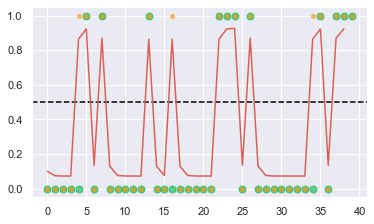

In [191]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
ax.axhline(0.5, color='k', linestyle='--')
# Calcalte the probability of beign in state 1 from the forward tracker
p1_fwd = [p[1] for p in est.forward_tracker]
ax.plot(p1_fwd[1:40])
ax.plot(state_ts[:40], 'o', color=sns.xkcd_rgb["shamrock"], markersize=7, alpha=0.6)
ax.plot(obs_ts[:40], 'o',color=sns.xkcd_rgb["tangerine"], markersize=4, alpha=0.6)

ax.set_ylim([-0.05,1.05])


In [192]:
# Now we can calculate the likelihood of this parameter
calc_likelihood(B, est.forward_tracker[1:], obs_ts)

97.63301882528573

In [193]:
# Now, we can write a function that loops over a bunch of values of the
# transition probability, and plots the likelihood function in terms of this
# parameter

def generate_likelihood_curve(B, obs_ts):
    est = infer.MarkovInfer(2, 2)
    a_vals = np.linspace(0, 1, 100)
    likelihood = []

    for a in a_vals:
        A_sample = np.array([[1 - a, a], [a, 1 - a]])
        est.forward_algo(obs_ts, A_sample, B)
        l = calc_likelihood(B, est.forward_tracker, obs_ts)
        likelihood.append(l)

    return likelihood, a_vals

In [194]:
likelihood, a_vals = generate_likelihood_curve(B, obs_ts)
a_ml = a_vals[np.argmin(likelihood)]
a_ml

0.7777777777777778

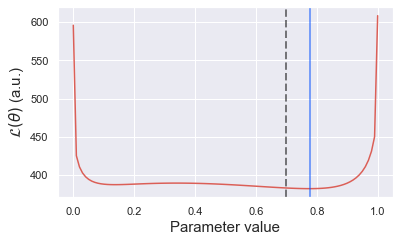

In [195]:
a_true = A[0,0]

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
ax.plot(a_vals, likelihood)
ax.axvline(a_true, color='k', linestyle='--', alpha=0.5, linewidth=2.0)
ax.axvline(a_ml, color=sns.xkcd_rgb["electric blue"], alpha=0.5, linewidth=2.0)
ax.set_xlabel(r"Parameter value", fontsize=15)
ax.set_ylabel(r"$\mathcal{L}(\theta)$ (a.u.)", fontsize=15)
plt.show()

So, from this we are able to produce a reasonable estiamte of the transition matrix parameters. Now, lets go one step further, and assume that we also want to determine the parameters in the emission matrix ($B$), while still assuming that both $A$ and $B$ are symmetric, and that the hidden state trajectory is known. 

Now, the likelihood function is 2-dimensional

In [109]:
# First, we need to re-write our function to generate the likelihood into a 2D routine
def generate_likelihood_surface(
    obs_ts: Iterable[int], sample_dim: Optional[int] = 10
):
    est = infer.MarkovInfer(2, 2)

    a_vals = np.linspace(0.01, 0.99, sample_dim)
    b_vals = np.linspace(0.01, 0.99, sample_dim)

    likelihood = np.zeros((sample_dim, sample_dim))

    for i, a in enumerate(a_vals):
        A_sample = np.array([[1 - a, a], [a, 1 - a]])
        for j, b in enumerate(b_vals):
            B_sample = np.array([[1 - b, b], [b, 1 - b]])

            est.forward_algo(obs_ts, A_sample, B_sample)
            try:
                l = calc_likelihood(B_sample, est.forward_tracker, obs_ts[1:])
            except RuntimeWarning:
                l = None
            likelihood[i, j] = l

    return likelihood, a_vals, b_vals

In [111]:
likelihood, aVals, bVals = generate_likelihood_surface(obs_ts, sample_dim=100)

In [83]:
# And we can find the optimal parameter combination
flat_idx = likelihood.argmin()
a_idx = flat_idx % 100
b_idx = flat_idx // 100
a_idx, b_idx

(26, 47)

In [84]:
likelihood[b_idx, a_idx]

333.67282181856734

In [85]:
np.min(likelihood)

333.67282181856734

In [86]:
# Now that means the optimal parameters are:
a_opt = aVals[a_idx]
b_opt = bVals[b_idx]
a_opt, b_opt

(0.2673737373737374, 0.47525252525252526)

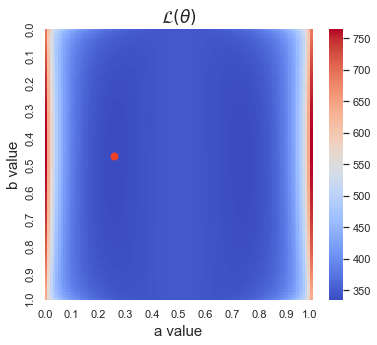

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

sns.heatmap(likelihood, cmap="coolwarm", ax=ax)
ax.plot([a_idx], [b_idx], 'o', markersize=7, color=sns.xkcd_rgb["tomato"])

idx_arr = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]

ax.set_xticks(idx_arr)
ax.set_yticks(idx_arr)

ax.set_xticklabels(np.round(aVals[idx_arr], 1))
ax.set_yticklabels(np.round(aVals[idx_arr], 1))

ax.set_xlabel(r"a value", fontsize=15)
ax.set_ylabel(r"b value", fontsize=15)
ax.set_title(r"$\mathcal{L}(\theta)$", fontsize=17)
plt.show()

So, this procedure (although it takes awhile for the resolution in the plot above) does appear to generally work. However, this far, we have been using the actual series of hidden states in time, which we will not, in general, have access to. This will result in a very large set of parameters when we incorporate that diretly into the likelihood function. However, we could speed things up by, instead of sampling the entire function, performing a local optimization on the likelihood surface (such as, for instance, gradient descent). Given that we start in the correct basin, this will lead to convergence towards the local minimum.

However, in the plot above, there is a competing local minima around the coordintate $(a, b) = (0.8, 0.05)$, and so we might erroneously infer that to be the optimal parameter set using local optimization, given that we were to start nearer to that local minimum. 

In the following notebook, we will run this local optimization scheme assuming a relatively close initia guess to the true dynamic parameters.